In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**knock70.py**

In [3]:
#knock50 train test valid
import pandas as pd
from sklearn.model_selection import train_test_split

#ファイルを読み込む
data = pd.read_csv('/content/drive/MyDrive/chapter08/newsCorpora.csv', sep = '\t', header = None, names = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

#事例（記事）を抽出する
publishers = ['Reuters', 'Huffington Post', 'Businessweek', '“Contactmusic.com', 'Daily Mail']
##isin:探す
data = data[data['PUBLISHER'].isin(publishers)]
data = data[['TITLE', 'CATEGORY']]

#分割する
##shuffle：分割する前dataをランダムにする
train, valid_test = train_test_split(data, test_size = 0.2, random_state = 0, shuffle = True, stratify = data['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, random_state=0, shuffle = True, stratify=valid_test['CATEGORY'])

In [4]:
#knock60の単語ベクトル
from gensim.models import KeyedVectors
file = '/content/drive/MyDrive/chapter07/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(file, binary = True)

In [5]:
#knock70
import string
import torch
def tensor1(text): #テキストの平均ベクトル化
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #マークをspaceに変換
  words = text.translate(table).split()  # スペースで分割してリスト化
  vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

  return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力 （multidimensional array）

# 特徴ベクトルxi
X_train = torch.stack([tensor1(text) for text in train['TITLE']])
X_valid = torch.stack([tensor1(text) for text in valid['TITLE']])
X_test = torch.stack([tensor1(text) for text in test['TITLE']])


# ラベルベクトルy
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

torch.save(X_train, '/content/drive/MyDrive/chapter08/X_train.pt')
torch.save(X_valid, '/content/drive/MyDrive/chapter08/X_valid.pt')
torch.save(X_test, '/content/drive/MyDrive/chapter08/X_test.pt')
torch.save(y_train, '/content/drive/MyDrive/chapter08/y_train.pt')
torch.save(y_valid, '/content/drive/MyDrive/chapter08/y_valid.pt')
torch.save(y_test, '/content/drive/MyDrive/chapter08/y_test.pt')

**knock71.py**

In [6]:
from torch import nn

#単層のニューラルネットワークを定義
class Net(nn.Module):
  def __init__(self, input, output):
    super().__init__() #親クラスのメソッドを呼び出す
    self.fc = nn.Linear(input, output, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0) #重みを更新

  def forward(self, x): #順伝播
    x = self.fc(x)
    return x

model = Net(300, 4)
y1 = torch.softmax(model(X_train[:1]), dim=-1)
Y1 = torch.softmax(model.forward(X_train[:4]), dim=-1)
print(y1)
print(Y1)

tensor([[0.2027, 0.6731, 0.0022, 0.1220]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2027, 0.6731, 0.0022, 0.1220],
        [0.2998, 0.2585, 0.0122, 0.4295],
        [0.3816, 0.3089, 0.0981, 0.2114],
        [0.7096, 0.1409, 0.0686, 0.0809]], grad_fn=<SoftmaxBackward0>)


**knock72.py**

In [7]:
criterion = nn.CrossEntropyLoss() #クロスエントロピー損失を計算する

loss = criterion(model(X_train[:1]), y_train[:1]) #(outputs, labels)
model.zero_grad() #勾配を0で初期化
loss.backward() #逆伝播を実行

print(f'損失: {loss}')
print(f'勾配:\n{model.fc.weight.grad}') #行列Wに関する勾配

損失: 1.5958482027053833
勾配:
tensor([[-4.8014e-02,  1.7012e-02, -4.6165e-02,  ...,  2.3318e-02,
         -8.7661e-02, -5.1021e-03],
        [ 4.0536e-02, -1.4362e-02,  3.8975e-02,  ..., -1.9687e-02,
          7.4008e-02,  4.3075e-03],
        [ 1.2948e-04, -4.5877e-05,  1.2450e-04,  ..., -6.2884e-05,
          2.3640e-04,  1.3759e-05],
        [ 7.3483e-03, -2.6036e-03,  7.0653e-03,  ..., -3.5688e-03,
          1.3416e-02,  7.8085e-04]])


In [8]:
loss1 = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
loss1.backward()

print(f'損失: {loss1}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 2.7517316341400146
勾配:
tensor([[ 0.0015,  0.0277, -0.0155,  ..., -0.0129, -0.0054, -0.0117],
        [ 0.0229,  0.0022,  0.0071,  ..., -0.0144,  0.0305,  0.0005],
        [-0.0438, -0.0311,  0.0111,  ...,  0.0411, -0.0401,  0.0137],
        [ 0.0194,  0.0012, -0.0026,  ..., -0.0138,  0.0150, -0.0024]])


**knock73.py**

In [9]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class dataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
  def __len__(self): #データセットのサイズを返す
    return len(self.y)
  def __getitem__(self, index): #indexに対応するデータを取得する
    return [self.X[index], self.y[index]]

#datasetを作成
dataset_train = dataset(X_train, y_train)
dataset_valid = dataset(X_valid, y_valid)
dataset_test = dataset(X_test, y_test)
#dataloaderを作成
dataloader_train = DataLoader(dataset_train, batch_size= 1, shuffle= False) #shuffle:データをランダムにシャッフルする
dataloader_valid = DataLoader(dataset_valid, batch_size= len(dataset_valid), shuffle= False)
dataloader_test = DataLoader(dataset_test, batch_size= len(dataset_test), shuffle= False)


In [10]:
model = Net(300, 4)
criterion = nn.CrossEntropyLoss() #loss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1) #optimizer,SGDを応用

#学習
num_epochs = 10
for epoch in range(num_epochs):
  model.train() #訓練モード
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    optimizer.zero_grad() #勾配をゼロで初期化
    outputs = model(inputs) #順伝播
    loss = criterion(outputs, labels)
    loss.backward() #逆伝播
    optimizer.step() #重みを更新
    loss_train += loss.item() #損失を記録
  loss_train = loss_train / i #バッチ単位の平均損失、最後のi

  #valid dataの損失
  model.eval()
  with torch.no_grad():
    inputs, labels = next(iter(dataloader_valid))
    outputs = model(inputs)
    loss_valid = criterion(outputs, labels)

  #lossを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')

epoch: 1, loss_train: 0.5680, loss_valid: 0.4187
epoch: 2, loss_train: 0.3674, loss_valid: 0.3731
epoch: 3, loss_train: 0.3319, loss_valid: 0.3542
epoch: 4, loss_train: 0.3131, loss_valid: 0.3435
epoch: 5, loss_train: 0.3008, loss_valid: 0.3366
epoch: 6, loss_train: 0.2920, loss_valid: 0.3319
epoch: 7, loss_train: 0.2853, loss_valid: 0.3286
epoch: 8, loss_train: 0.2800, loss_valid: 0.3263
epoch: 9, loss_train: 0.2757, loss_valid: 0.3246
epoch: 10, loss_train: 0.2722, loss_valid: 0.3234


**knock74.py**

In [11]:
def calculate_accuracy(model, loader):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad(): #バッチごとにデータを取得
    for inputs, labels in loader:
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
  return correct / len(loader.dataset)

acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(acc_train)
print(acc_test)

0.9115174920490686
0.8982742960944596


**knock75.py**

In [12]:
def cal_loss_acc(model, criterion, loader): #モデルの損失と正解率の計算
  model.eval()
  loss = 0.0
  total = 0 # 総サンプル数
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item() #損失を計算し、累積する
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total

In [13]:
model = Net(300, 4)
criterion = nn.CrossEntropyLoss() #loss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1) #optimizer,SGDを応用

#学習
num_epochs = 10
train1 = []
valid1 = []

for epoch in range(num_epochs):
  model.train() #訓練モード
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    optimizer.zero_grad() #勾配をゼロで初期化
    outputs = model(inputs) #順伝播
    loss = criterion(outputs, labels)
    loss.backward() #逆伝播
    optimizer.step() #重みを更新

  loss_train, acc_train = cal_loss_acc(model, criterion, dataloader_train)
  loss_valid, acc_valid = cal_loss_acc(model, criterion, dataloader_valid)
  train1.append([loss_train, acc_train]) #記録
  valid1.append([loss_valid, acc_valid])

  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

epoch: 1, loss_train: 0.3733, accuracy_train: 0.8652, loss_valid: 0.3998, accuracy_valid: 0.8674
epoch: 2, loss_train: 0.3252, accuracy_train: 0.8874, loss_valid: 0.3629, accuracy_valid: 0.8801
epoch: 3, loss_train: 0.3037, accuracy_train: 0.8964, loss_valid: 0.3479, accuracy_valid: 0.8792
epoch: 4, loss_train: 0.2906, accuracy_train: 0.9022, loss_valid: 0.3397, accuracy_valid: 0.8865
epoch: 5, loss_train: 0.2817, accuracy_train: 0.9060, loss_valid: 0.3346, accuracy_valid: 0.8901
epoch: 6, loss_train: 0.2751, accuracy_train: 0.9082, loss_valid: 0.3313, accuracy_valid: 0.8928
epoch: 7, loss_train: 0.2700, accuracy_train: 0.9094, loss_valid: 0.3290, accuracy_valid: 0.8928
epoch: 8, loss_train: 0.2659, accuracy_train: 0.9108, loss_valid: 0.3273, accuracy_valid: 0.8974
epoch: 9, loss_train: 0.2626, accuracy_train: 0.9109, loss_valid: 0.3261, accuracy_valid: 0.8983
epoch: 10, loss_train: 0.2597, accuracy_train: 0.9122, loss_valid: 0.3253, accuracy_valid: 0.8974


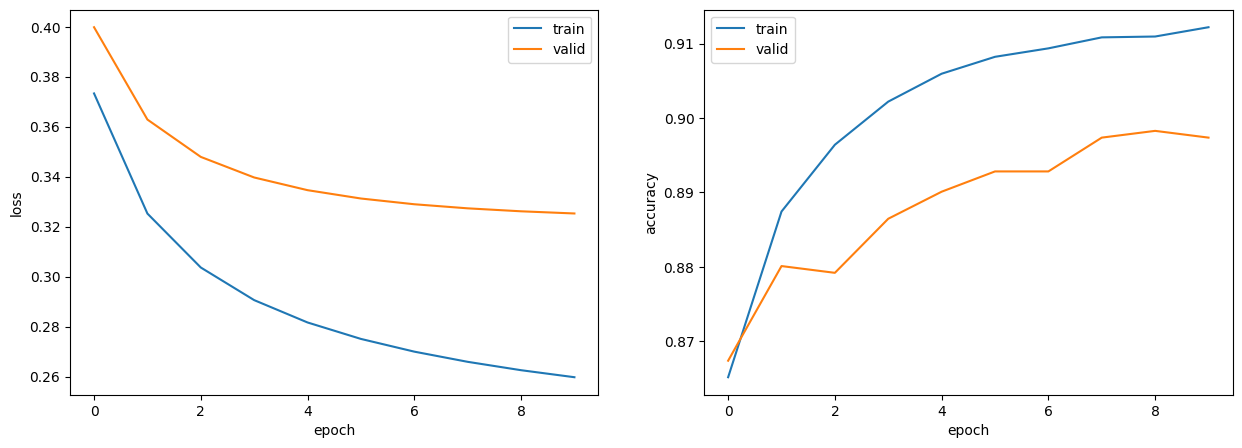

In [14]:
import numpy as np
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5)) #1行2列の図
ax[0].plot(np.array(train1).T[0], label='train') #loss
ax[0].plot(np.array(valid1).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(train1).T[1], label='train') #accuracy
ax[1].plot(np.array(valid1).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

**knock76.py**

In [16]:
model = Net(300, 4)
criterion = nn.CrossEntropyLoss() #loss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1) #optimizer,SGDを応用

#学習
num_epochs = 10

for epoch in range(num_epochs):
  model.train() #訓練モード
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    optimizer.zero_grad() #勾配をゼロで初期化
    outputs = model(inputs) #順伝播
    loss = criterion(outputs, labels)
    loss.backward() #逆伝播
    optimizer.step() #重みを更新

  loss_train, acc_train = cal_loss_acc(model, criterion, dataloader_train)
  loss_valid, acc_valid = cal_loss_acc(model, criterion, dataloader_valid)

  #チェックポイントの保存
  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

epoch: 1, loss_train: 0.3801, accuracy_train: 0.8694, loss_valid: 0.4053, accuracy_valid: 0.8656
epoch: 2, loss_train: 0.3301, accuracy_train: 0.8872, loss_valid: 0.3672, accuracy_valid: 0.8792
epoch: 3, loss_train: 0.3073, accuracy_train: 0.8956, loss_valid: 0.3509, accuracy_valid: 0.8847
epoch: 4, loss_train: 0.2934, accuracy_train: 0.8988, loss_valid: 0.3413, accuracy_valid: 0.8837
epoch: 5, loss_train: 0.2837, accuracy_train: 0.9016, loss_valid: 0.3349, accuracy_valid: 0.8874
epoch: 6, loss_train: 0.2765, accuracy_train: 0.9053, loss_valid: 0.3305, accuracy_valid: 0.8901
epoch: 7, loss_train: 0.2710, accuracy_train: 0.9070, loss_valid: 0.3274, accuracy_valid: 0.8919
epoch: 8, loss_train: 0.2666, accuracy_train: 0.9080, loss_valid: 0.3252, accuracy_valid: 0.8937
epoch: 9, loss_train: 0.2630, accuracy_train: 0.9094, loss_valid: 0.3236, accuracy_valid: 0.8937
epoch: 10, loss_train: 0.2600, accuracy_train: 0.9112, loss_valid: 0.3225, accuracy_valid: 0.8910


**knock77.py**

In [25]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

for epoch in range(num_epochs):
  s_time = time.time() #エポックの開始時刻
  model.train() #訓練モード
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    optimizer.zero_grad() #勾配をゼロで初期化
    outputs = model(inputs) #順伝播
    loss = criterion(outputs, labels)
    loss.backward() #逆伝播
    optimizer.step() #重みを更新

  loss_train, acc_train = cal_loss_acc(model, criterion, dataloader_train)
  loss_valid, acc_valid = cal_loss_acc(model, criterion, dataloader_valid)

  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

  e_time = time.time() #終了時刻

epoch: 1, loss_train: 0.3253, accuracy_train: 0.8873, loss_valid: 0.3502, accuracy_valid: 0.8719
epoch: 2, loss_train: 0.3037, accuracy_train: 0.8949, loss_valid: 0.3351, accuracy_valid: 0.8801
epoch: 3, loss_train: 0.2906, accuracy_train: 0.9003, loss_valid: 0.3272, accuracy_valid: 0.8837
epoch: 4, loss_train: 0.2816, accuracy_train: 0.9039, loss_valid: 0.3226, accuracy_valid: 0.8865
epoch: 5, loss_train: 0.2749, accuracy_train: 0.9050, loss_valid: 0.3197, accuracy_valid: 0.8837
epoch: 6, loss_train: 0.2697, accuracy_train: 0.9078, loss_valid: 0.3179, accuracy_valid: 0.8847
epoch: 7, loss_train: 0.2656, accuracy_train: 0.9087, loss_valid: 0.3168, accuracy_valid: 0.8856
epoch: 8, loss_train: 0.2622, accuracy_train: 0.9099, loss_valid: 0.3161, accuracy_valid: 0.8856
epoch: 9, loss_train: 0.2594, accuracy_train: 0.9117, loss_valid: 0.3158, accuracy_valid: 0.8910
epoch: 10, loss_train: 0.2570, accuracy_train: 0.9120, loss_valid: 0.3156, accuracy_valid: 0.8919


In [31]:
#モデルの学習
for batch_size in [2 ** i for i in range(11)]: #2のべき乗
  s_time = time.time()
  model = Net(300, 4)
  criterion = nn.CrossEntropyLoss() #loss
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-1) #optimizer,SGDを応用
  e_time = time.time()
  print(f'バッチサイズ: {batch_size}')
  print(e_time - s_time)

バッチサイズ: 1
0.0016329288482666016
バッチサイズ: 2
0.0005950927734375
バッチサイズ: 4
0.00045371055603027344
バッチサイズ: 8
0.0004012584686279297
バッチサイズ: 16
0.000385284423828125
バッチサイズ: 32
0.0003788471221923828
バッチサイズ: 64
0.00033283233642578125
バッチサイズ: 128
0.00026869773864746094
バッチサイズ: 256
0.00023126602172851562
バッチサイズ: 512
0.0002532005310058594
バッチサイズ: 1024
0.0002849102020263672


**knock78.py**

In [40]:
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    s_time = time.time() #開始時刻の記録
    model.train() #訓練モード
    for inputs, labels in dataloader_train:
      optimizer.zero_grad() #勾配をゼロで初期化

      #順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    #損失と正解率の算出
    loss_train, acc_train = cal_loss_acc(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = cal_loss_acc(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    #チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    e_time = time.time() #終了時刻の記録

    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

  return {'train': log_train, 'valid': log_valid}

In [36]:
for batch_size in [2 ** i for i in range(11)]: #2のべき乗
  s_time = time.time()
  model = Net(300, 4)
  criterion = nn.CrossEntropyLoss() #loss
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-1) #optimizer,SGDを応用
  device = torch.device
  e_time = time.time()
  print(f'バッチサイズ: {batch_size}')
  print(e_time - s_time)

バッチサイズ: 1
0.001707315444946289
バッチサイズ: 2
0.0019736289978027344
バッチサイズ: 4
0.001451730728149414
バッチサイズ: 8
0.0016887187957763672
バッチサイズ: 16
0.0015254020690917969
バッチサイズ: 32
0.0013303756713867188
バッチサイズ: 64
0.0003345012664794922
バッチサイズ: 128
0.0003459453582763672
バッチサイズ: 256
0.00030541419982910156
バッチサイズ: 512
0.00030517578125
バッチサイズ: 1024
0.004092693328857422


**knock79.py**

In [47]:
from torch.nn import functional as F

#多層のニューラルネットワークを定義
class Net(nn.Module):
  def __init__(self, input_size, mid_size, output_size, mid_layers):
    super().__init__() #親クラスのメソッドを呼び出す
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size, mid_size)
    self.fc_mid = nn.Linear(mid_size, mid_size) #中間層
    self.fc_out = nn.Linear(mid_size, output_size) #出力層
    self.bn = nn.BatchNorm1d(mid_size) #バッチ正規化層

  def forward(self, x): #順伝播
    x = F.relu(self.fc(x))
    for _ in range(self.mid_layers): #中間層の数だけ繰り返す
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))

    return x

In [67]:
from torch import optim

def cal_loss_acc(model, criterion, loader): #モデルの損失と正解率の計算
  model.eval()
  loss = 0.0
  total = 0 # 総サンプル数
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  model.to(device)
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)
  train1 = []
  valid1 = []

  for epoch in range(num_epochs):
   s_time = time.time
   model.train() #訓練モード

   for inputs, labels in dataloader_train:
    optimizer.zero_grad() #勾配をゼロで初期化
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model.forward(inputs) #順伝播
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step() #重みを更新

  loss_train, acc_train = cal_loss_acc(model, criterion, dataloader_train, device)
  loss_valid, acc_valid = cal_loss_acc(model, criterion, dataloader_valid, device)
  train1.append([loss_train, acc_train]) #記録
  valid1.append([loss_valid, acc_valid])

  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
  e_time = time.time()
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')
  scheduler.step() #学習率スケジューラを1ステップ進む


In [68]:
#モデルの学習
model = Net(300, 200, 4, 1) #入力サイズ300、中間層サイズ200、出力サイズ4.中間層の数は1
criterion = nn.CrossEntropyLoss() #loss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) #optimizer,SGDを応用 学習率:1e-3
device = torch.device('cuda')

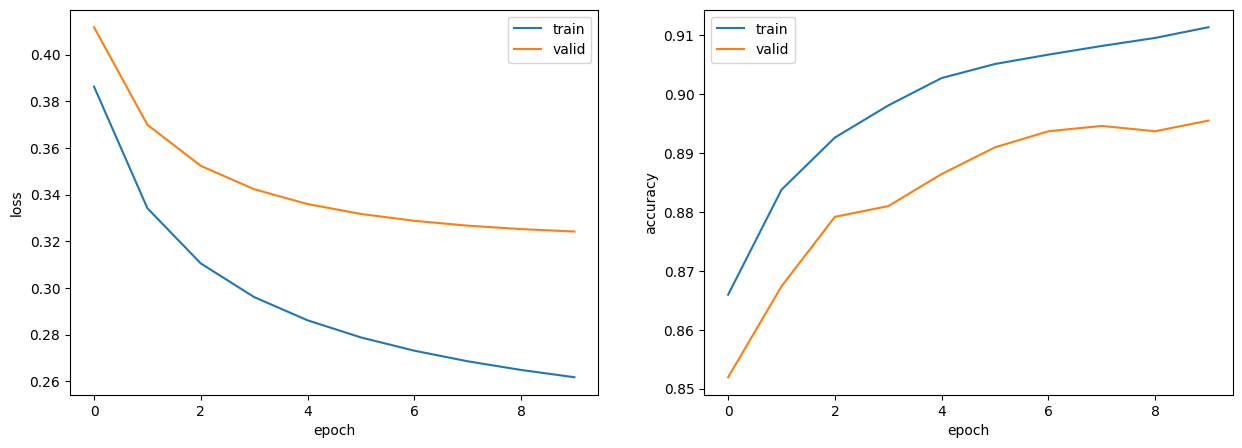

In [69]:
#エポックごとの損失と正解率
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(train1).T[0], label='train')
ax[0].plot(np.array(valid1).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(train1).T[1], label='train')
ax[1].plot(np.array(valid1).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [ ]:
#正解率
def cal_acc(model, loader, device):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return correct / total

acc_train = cal_acc(model, dataloader_train, device)
acc_test = cal_acc(model, dataloader_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')